In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("="*70)
print("客户价值和留存分析".center(70))
print("="*70)

print("\n[STEP 1] 数据加载与清洗...")

# Load the dataset
try:
    df = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')
except FileNotFoundError:
    print("错误：未找到 'online_retail_II.csv' 文件。请确保文件位于正确路径。")
    exit()

# Data Cleaning
df_clean = df.copy()
# Remove rows with missing Customer ID
df_clean = df_clean.dropna(subset=['Customer ID'])
# Remove negative Quantity (returns)
df_clean = df_clean[df_clean['Quantity'] > 0]
# Remove transactions with zero or negative price
df_clean = df_clean[df_clean['Price'] > 0]
# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
# Calculate total value for each transaction line
df_clean['TotalValue'] = df_clean['Quantity'] * df_clean['Price']

print(f"✓ 原始数据条数: {len(df):,}")
print(f"✓ 清洗后数据条数: {len(df_clean):,}")
print(f"✓ 数据清洗完成。")

                              客户价值和留存分析                               

[STEP 1] 数据加载与清洗...
✓ 原始数据条数: 1,067,371
✓ 清洗后数据条数: 805,549
✓ 数据清洗完成。


In [4]:
print("\n[STEP 2] 客户价值细分 (RFM 分析)...")

# Calculate RFM metrics
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'Invoice': 'nunique',                                           # Frequency
    'TotalValue': 'sum'                                             # Monetary
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create RFM scores based on manual bins (corrected approach)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')

# Manual scoring for Frequency and Monetary due to data distribution
# For Frequency, a higher value means a better score
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=[0, 1, 2, 4, rfm['Frequency'].max()], labels=[1, 2, 3, 4], duplicates='drop', include_lowest=True)

# For Monetary, a higher value means a better score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

# Handle any potential remaining NaN values from manual cuts by filling them
rfm['F_Score'] = rfm['F_Score'].astype(float).fillna(1).astype(int)
rfm['R_Score'] = rfm['R_Score'].astype(float).fillna(1).astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(float).fillna(1).astype(int)


rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Define customer segments based on RFM scores
def rfm_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r == 4 and (f in [4, 3]) and (m in [4, 3]):
        return '高价值忠诚客户 (Champions)'
    elif r == 4 and (f in [2, 1]) and (m in [2, 1]):
        return '新客户 (New Customers)'
    elif r == 1 and f == 1 and m == 1:
        return '流失客户 (Lost Customers)'
    elif r in [2, 3] and f in [2, 3] and m in [2, 3]:
        return '潜力客户 (Potential)'
    elif r in [1, 2] and f in [3, 4] and m in [3, 4]:
        return '高价值流失风险客户 (At Risk)'
    else:
        return '其他'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print("\n📊 客户细分结果:")
print(rfm['Segment'].value_counts())
print("\n🔍 关键指标摘要:")
segment_metrics = rfm.groupby('Segment').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Customer_Count=('Monetary', 'count')
).round(2).sort_values(by='Customer_Count', ascending=False)
print(segment_metrics)



[STEP 2] 客户价值细分 (RFM 分析)...

📊 客户细分结果:
Segment
其他                       2438
高价值忠诚客户 (Champions)      1080
潜力客户 (Potential)          934
流失客户 (Lost Customers)     627
高价值流失风险客户 (At Risk)       577
新客户 (New Customers)       222
Name: count, dtype: int64

🔍 关键指标摘要:
                       Avg_Recency  Avg_Frequency  Avg_Monetary  \
Segment                                                           
其他                          211.40           4.19       1700.57   
高价值忠诚客户 (Champions)          11.31          17.24       9679.63   
潜力客户 (Potential)            153.59           2.89        912.44   
流失客户 (Lost Customers)       548.94           1.00        178.84   
高价值流失风险客户 (At Risk)         285.93           7.76       3633.49   
新客户 (New Customers)          14.40           1.53        371.95   

                       Customer_Count  
Segment                                
其他                               2438  
高价值忠诚客户 (Champions)              1080  
潜力客户 (Potential)                  934 


[STEP 3] 客户留存率分析 (队列分析)...

📊 客户留存矩阵 (按月):
CohortPeriod   0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                 
2009-12       1.0  0.353  0.334  0.425  0.380  0.359  0.377  0.342  0.336   
2010-01       1.0  0.206  0.311  0.305  0.264  0.300  0.258  0.230  0.279   
2010-02       1.0  0.238  0.225  0.291  0.246  0.201  0.193  0.286  0.254   
2010-03       1.0  0.190  0.230  0.242  0.233  0.203  0.246  0.302  0.275   
2010-04       1.0  0.194  0.194  0.163  0.184  0.224  0.276  0.262  0.105   
2010-05       1.0  0.157  0.169  0.173  0.177  0.256  0.213  0.126  0.059   
2010-06       1.0  0.174  0.189  0.204  0.230  0.285  0.126  0.089  0.081   
2010-07       1.0  0.156  0.183  0.296  0.290  0.140  0.113  0.145  0.145   
2010-08       1.0  0.204  0.296  0.321  0.173  0.117  0.099  0.123  0.136   
2010-09       1.0  0.226  0.235  0.123  0.091  0.103  0.136  0.099  0.128   
2010-10       1.0  0.257  0.146 

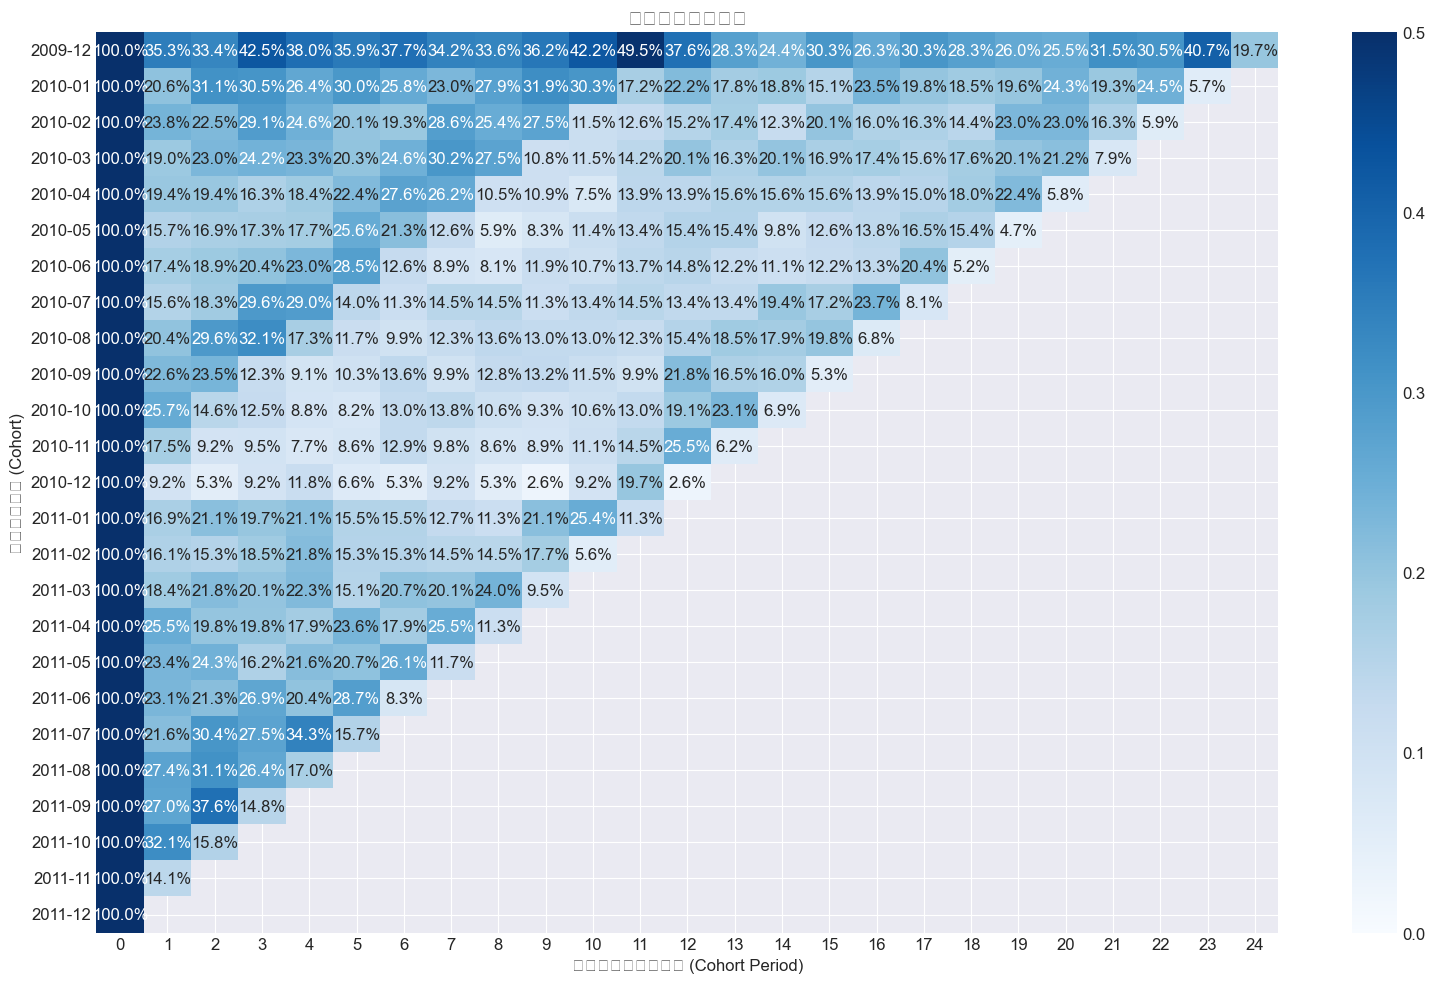

In [5]:
print("\n[STEP 3] 客户留存率分析 (队列分析)...")

# Create a monthly cohort for each customer
df_cohort = df_clean.copy()
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['CohortMonth'] = df_cohort.groupby('Customer ID')['InvoiceMonth'].transform('min')

# Count unique customers per cohort per month
cohort_data = df_cohort.groupby(['CohortMonth', 'InvoiceMonth'])['Customer ID'].nunique().reset_index()

# Calculate cohort period (months since first purchase)
cohort_data['CohortPeriod'] = (cohort_data['InvoiceMonth'] - cohort_data['CohortMonth']).apply(lambda x: x.n)

# Pivot table to get the cohort retention matrix
cohort_pivot = cohort_data.pivot_table(index='CohortMonth', columns='CohortPeriod', values='Customer ID')
cohort_counts = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_counts, axis=0).round(3)

print("\n📊 客户留存矩阵 (按月):")
print(retention_matrix)

# Visualize the retention matrix
plt.figure(figsize=(16, 10))
sns.heatmap(retention_matrix, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=0.5).set_title('客户留存率热力图')
plt.xlabel('距离首次购买的月数 (Cohort Period)')
plt.ylabel('首次购买月份 (Cohort)')
plt.tight_layout()
plt.savefig('customer_retention_heatmap.png')
print("✓ 客户留存率热力图已保存为 'customer_retention_heatmap.png'")